In [1]:
# 以沪深300数据集为例，构建特征和目标值，拟合特征与目标值，并评估模型
# 数据已经经过了初步清洗，剔除掉每天的涨跌停股和ST股，并使用后复权价格
# 如果不做回测，可以注释掉一切带"_test"的行

import pandas as pd
from scutquant import scutquant, alpha

In [2]:
# 读取数据
df_train = pd.read_csv('D:/Desktop/CSI300.csv')
df_test = pd.read_csv('D:/Desktop/CSI300_test.csv')
df_train.set_index(['datetime', 'instrument'], inplace=True)
df_test.set_index(['datetime', 'instrument'], inplace=True)

df = pd.concat([df_train, df_test], axis=0)

#sup_data = pd.read_csv('D:/Desktop/SH000300.csv')  # supplemental_data
#df = scutquant.join_data(df, sup_data, time='datetime', col=['idx_close'], index=['datetime', 'instrument'])

df

open       close        high         low  \
datetime   instrument                                                   
2010-01-04 300003.SZ    51.590000   51.500000   51.850000   51.100000   
           300014.SZ    39.700000   39.470000   39.900000   39.240000   
           300015.SZ    48.970000   48.770000   49.190000   48.550000   
           300033.SZ    72.010000   74.570000   76.060000   71.610000   
           600000.SH    64.829142   62.928517   64.947931   62.839425   
...                           ...         ...         ...         ...   
2022-12-23 688363.SH   130.338644  130.842543  133.513211  129.078895   
           688396.SH    53.248294   52.735905   54.052042   52.344078   
           688561.SH    61.590000   67.160000   68.190000   61.590000   
           688599.SH    55.856185   54.938671   56.263968   53.909017   
           688981.SH    40.900000   41.060000   41.330000   40.830000   

                           volume        amount  
datetime   instrument                            
2010-01-04 300003.SZ     842437.0  4.328901e+07  
           300014.SZ     727706.0  2.873182e+07  
           300015.SZ     740314.0  3.613862e+07  
           300033.SZ    3627417.0  2.702477e+08  
           600000.SH   66191338.0  1.419984e+09  
...                           ...           ...  
2022-12-23 688363.SH    2334792.0  3.036193e+08  
           688396.SH    3462319.0  1.820840e+08  
           688561.SH    3554834.0  2.353862e+08  
           688599.SH   10072858.0  5.395502e+08  
           688981.SH    7428877.0  3.055459e+08  

[651282 rows x 6 columns]

In [3]:
# 清洗数据(由于原始数据已经经过了初步清洗，所以以下步骤可以省去)

# 查看缺失值和数据类型
df.info()
# 查看是否存在异常数据
#df.describe()
# 处理缺失值
#df.dropna(axis=1, how='all', inplace=True)  # 去除掉全为缺失值的列
#df = df.groupby(['instrument']).fillna(method='ffill').dropna()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 651282 entries, ('2010-01-04', '300003.SZ') to ('2022-12-23', '688981.SH')
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    651282 non-null  float64
 1   close   651282 non-null  float64
 2   high    651282 non-null  float64
 3   low     651282 non-null  float64
 4   volume  651282 non-null  float64
 5   amount  651282 non-null  float64
dtypes: float64(6)
memory usage: 32.4+ MB


In [4]:
# 下面开始构造目标值和特征

df['label'] = scutquant.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

feature_kwargs = {
    'data': df,
    'price': 'close',
    'label': 'label',
    'open': 'open',
    'volume': 'volume',
    'amount': 'amount',
    'high': 'high',
    'low': 'low',
    'shift': 2,
    'groupby': 'instrument'
}
features = alpha.make_factors(feature_kwargs, windows=[5, 10, 20, 30, 60])
X = pd.concat([features, df['label']], axis=1)

# 伪市场因子,需要读取supplemental data
# df['idx_ret'] = scutquant.price2ret(df['idx_close'], shift1=1, shift2=0, groupby='instrument')
#X['market'] = df['idx_ret'] / df['close']
X.describe()

,label0,label1,label2,label3,label4,label5,label6,label7,label8,label9,...,rsv10,rsv20,rsv30,rsv60,klen5,klen10,klen20,klen30,klen60,label
count,650662.000000,650352.000000,650042.000000,649732.000000,649422.000000,649112.000000,648802.000000,648492.000000,648182.000000,647872.000000,...,648492.000000,645392.000000,642292.000000,632992.000000,650042.000000,648492.000000,645392.000000,642292.000000,632992.000000,650662.000000
mean,0.001135,0.001137,0.001138,0.001139,0.001146,0.001155,0.001156,0.001158,0.001158,0.001159,...,12.950646,12.897034,12.845541,12.657972,0.034986,0.034986,0.035005,0.035034,0.035124,0.001135
std,0.040568,0.040576,0.040582,0.040591,0.040598,0.040604,0.040612,0.040620,0.040628,0.040636,...,73.254734,72.982316,72.850301,71.642050,0.016861,0.015727,0.014814,0.014334,0.013537,0.040568
min,-0.800138,-0.800138,-0.800138,-0.800138,-0.800138,-0.800138,-0.800138,-0.800138,-0.800138,-0.800138,...,-0.999744,-0.999736,-0.999736,-0.999725,0.001666,0.003968,0.005229,0.005450,0.005886,-0.800138
25%,-0.012942,-0.012945,-0.012945,-0.012946,-0.012939,-0.012924,-0.012926,-0.012926,-0.012931,-0.012931,...,-0.815811,-0.816737,-0.817311,-0.819934,0.022901,0.023718,0.024393,0.024754,0.025437,-0.012942
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.089285,-0.093664,-0.099214,-0.114001,0.032174,0.032700,0.033067,0.033275,0.033691,0.000000
75%,0.012839,0.012844,0.012846,0.012852,0.012862,0.012869,0.012873,0.012876,0.012876,0.012881,...,4.149272,4.124968,4.100062,4.023037,0.043721,0.043438,0.043270,0.043163,0.042993,0.012839
max,5.026166,5.026166,5.026166,5.026166,5.026166,5.026166,5.026166,5.026166,5.026166,5.026166,...,6378.559821,6654.432678,6708.836760,6820.357592,0.184640,0.158079,0.138242,0.124034,0.110373,5.026166


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 580608 entries, ('2010-01-04', '300003.SZ') to ('2021-12-31', '688981.SH')
Columns: 161 entries, label0 to label
dtypes: float64(161)
memory usage: 715.5+ MB
None
X_mis= 0.8162443721449932
clean dataset done 

pop label done 

label norm done 



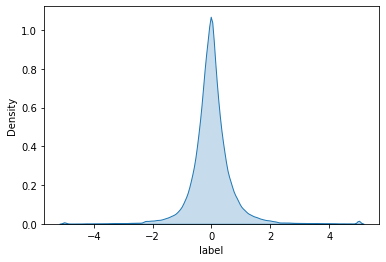

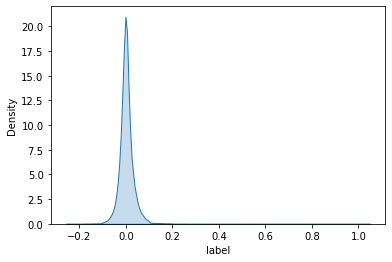

norm data done 

label0    0.101640
label1    0.075291
close0    0.071236
high0     0.067774
open0     0.065353
            ...   
STD5      0.000000
ksft30    0.000000
ma20      0.000000
klen5     0.000000
ma30      0.000000
Name: MI Scores, Length: 160, dtype: float64
count    160.000000
mean       0.025059
std        0.023694
min        0.000000
25%        0.005159
50%        0.011661
75%        0.051257
max        0.101640
Name: MI Scores, dtype: float64
std5 will be dropped
ma5 will be dropped
kmid30 will be dropped
kmid10 will be dropped
STD5 will be dropped
ksft30 will be dropped
ma20 will be dropped
klen5 will be dropped
ma30 will be dropped
all works done 



In [5]:
# 先拆分出测试集，然后做特征工程、数据清洗，并根据mutual information score选择特征

X_test = X[X.index.isin(df_test.index)]
X = X[~X.index.isin(df_test.index)]

# 使用auto_process()自动处理训练集和验证集(将在以后的版本完善拆分数据集的函数，使其能够同时处理训练、验证和测试集)
# select需要消耗大量时间，但可以过滤掉噪声。使用时需要在时间开销和模型性能之间权衡
x_train, x_valid, y_train, y_valid, ymean, ystd = scutquant.auto_process(X, 'label', groupby='instrument', select=True)

In [6]:
# 手动处理测试集
X_test = X_test.groupby(['instrument']).fillna(method='ffill').dropna()
x_test = X_test.copy()
y_test = x_test.pop('label')
col = x_train.columns
x_test = x_test[col]
x_test = scutquant.zscorenorm(x_test)

In [7]:
x_train.head(5)

label0    label1    label2    label3    label4  \
datetime   instrument                                                     
2010-04-08 600009.SH   0.055619 -0.283412 -0.005737  0.189235  0.055327   
           600010.SH  -0.485455  0.540235  0.126517  0.502992  0.076851   
           600015.SH  -0.669581 -0.396540  0.469332 -0.171532 -0.065546   
           600016.SH  -0.385023 -0.321622  0.028562 -0.000739  0.146467   
           600018.SH  -0.312997 -0.150381 -0.029889  0.131537  0.050802   

                         label5    label6    label7    label8    label9  ...  \
datetime   instrument                                                    ...   
2010-04-08 600009.SH  -0.331570  0.042404  0.164894  0.634979 -0.496941  ...   
           600010.SH  -0.242264 -0.240250  0.397820  0.077392 -0.083646  ...   
           600015.SH   0.040700 -0.083170  1.004401  1.299635 -0.395502  ...   
           600016.SH  -0.349469  0.057251  0.847238  0.432902 -0.364478  ...   
           600018.SH  -0.230888 -0.030154  0.254215  0.383528 -0.315855  ...   

                          hml60      rsv5     rsv10     rsv20     rsv30  \
datetime   instrument                                                     
2010-04-08 600009.SH   0.252126 -0.184676 -0.185228 -0.186136 -0.186068   
           600010.SH   0.264661 -0.190348 -0.190307 -0.190979 -0.190827   
           600015.SH   0.274632 -0.189119 -0.189173 -0.189995 -0.189861   
           600016.SH   0.282831 -0.179811 -0.180516 -0.182218 -0.182198   
           600018.SH   0.290006 -0.181640 -0.181421 -0.183449 -0.183242   

                          rsv60    klen10    klen20    klen30    klen60  
datetime   instrument                                                    
2010-04-08 600009.SH  -0.184674  3.752708  2.199810  1.834966  1.666414  
           600010.SH  -0.189474  4.153007  2.202049  2.022593  1.745299  
           600015.SH  -0.188500  4.364991  2.655119  2.233508  1.820953  
           600016.SH  -0.180793  4.778867  2.871260  2.361969  1.875025  
           600018.SH  -0.182013  4.847178  2.933574  2.442729  1.921177  

[5 rows x 151 columns]

In [8]:
# 拟合模型

xgb_params = {
    'est': 800,
    'eta': 0.0421,
    'colsamp': 0.9325,
    'subsamp': 0.8789,
    'max_depth': 10,
    'l1': 205.6999,
    'l2': 580.9768,
    'early_stopping_rounds': 20
}
model = scutquant.hybrid(lrg_method='ridge', xgb_params=xgb_params, weight=[0.4, 0.6])
model.fit(x_train, y_train, x_valid, (y_valid-ymean)/ystd)

pred = model.predict(x_test)
pred = pd.DataFrame(pred, columns=["predict"], index=x_test.index)
pred += ymean
pred *= ystd

[0]	validation_0-rmse:0.83824
[1]	validation_0-rmse:0.82694
[2]	validation_0-rmse:0.81638
[3]	validation_0-rmse:0.80658
[4]	validation_0-rmse:0.79759
[5]	validation_0-rmse:0.78932
[6]	validation_0-rmse:0.78164
[7]	validation_0-rmse:0.77453
[8]	validation_0-rmse:0.76792
[9]	validation_0-rmse:0.76163
[10]	validation_0-rmse:0.75596
[11]	validation_0-rmse:0.75064
[12]	validation_0-rmse:0.74581
[13]	validation_0-rmse:0.74138
[14]	validation_0-rmse:0.73729
[15]	validation_0-rmse:0.73353
[16]	validation_0-rmse:0.73008
[17]	validation_0-rmse:0.72689
[18]	validation_0-rmse:0.72391
[19]	validation_0-rmse:0.72135
[20]	validation_0-rmse:0.71885
[21]	validation_0-rmse:0.71658
[22]	validation_0-rmse:0.71446
[23]	validation_0-rmse:0.71252
[24]	validation_0-rmse:0.71077
[25]	validation_0-rmse:0.70911
[26]	validation_0-rmse:0.70764
[27]	validation_0-rmse:0.70633
[28]	validation_0-rmse:0.70516
[29]	validation_0-rmse:0.70388
[30]	validation_0-rmse:0.70283
[31]	validation_0-rmse:0.70189
[32]	validation_0-

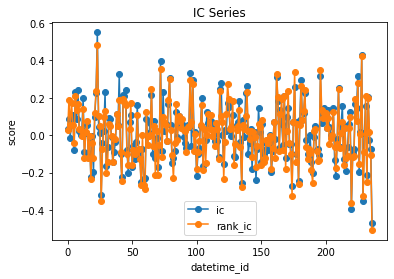

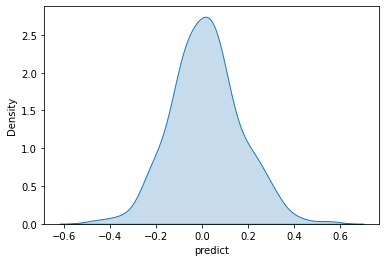

ic= 0.014126256956435301 icir= 0.09350193826164659 rank_ic= 0.008395213687606465 rank_icir= 0.055370647639740166


In [9]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

In [10]:
# 使用pearson相关系数评判拟合优度
r = scutquant.pearson_corr(pred.values, y_test)
r[0]

0.050857151668671594

In [11]:
# 以下为回测部分
from scutquant import executor

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, time='datetime', price='close')

backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "StrictTopKStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票, 并自动平仓. 
        "kwargs": {
            "auto_offset": True,
            "offset_freq": 2,
            "buy_only": True,  # =True时，只做多不做空
            "risk_degree": 0.65
        }
    },
    
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    
    "trade_params": {
        "cost_buy": 0.0015,
        "cost_sell": 0.0005,
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): -0.07799407745714723
std: 0.03427067588174166
E(r_benchmark): -0.13770665127800302
std_benchmark: 0.05320053573200636 

Cumulative Rate of Return: -0.11978411813804202
Cumulative Rate of Return(benchmark): -0.19375655308159512
Cumulative Excess Rate of Return: 0.0739724349435531 

Max Drawdown: -0.16630985107797658
Max Drawdown(benchmark): -0.23812980368328573 

Sharpe Ratio: -2.278223794225364
Information Ratio: 1.742380979788869


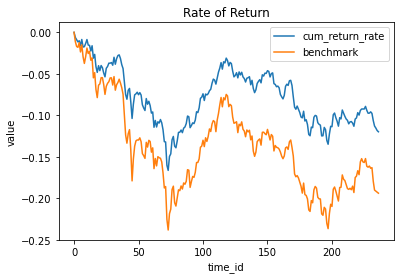

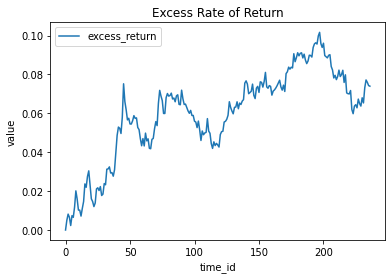

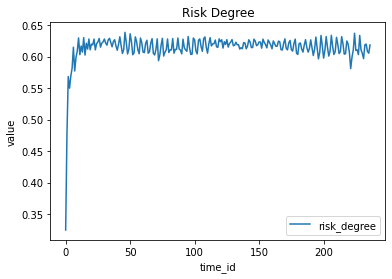

In [12]:
# 报告回测结果
# 对比2022年主动管理型基金的业绩，这表现算是在平均线以上
from scutquant import report

user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365)  # 无风险收益率默认为年化3%，可以通过参数rf调节

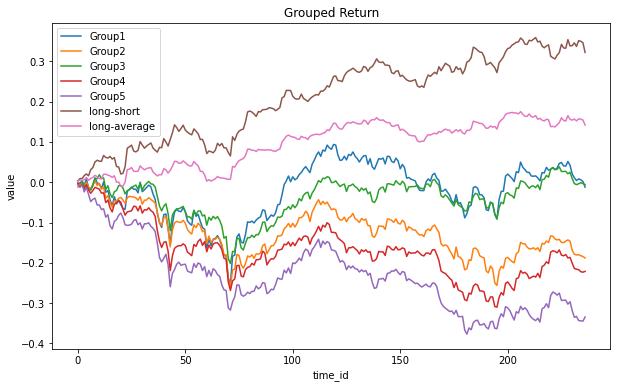

In [13]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)